In [1]:
import pandas as pd
import sys 
import numpy as np 
from sklearn.metrics.pairwise import euclidean_distances 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
np.set_printoptions(precision=3)

sys.path.append('/data/ddmg/slabs/structured_labels/')

In [2]:
def create_dummy_data(n, stdev=0.0):
    x00 = np.random.normal([0,0], [stdev, stdev], size=(n[0], 2))
    y00 = np.zeros((n[0], 2))

    x11 = np.random.normal([1,1], [stdev, stdev], size=(n[1], 2))
    y11 = np.ones((n[1], 2))
    
    x10 = np.random.normal([1,0], [stdev, stdev], size=(n[2], 2))
    y10 = np.hstack([np.ones((n[2], 1)), np.zeros((n[2], 1))])
    
    x01 = np.random.normal([0,1], [stdev, stdev], size=(n[3], 2))
    y01 = np.hstack([np.zeros((n[3], 1)), np.ones((n[3], 1))])
    
    x = np.concatenate([x11, x01, x10, x00], axis=0)
    y = np.concatenate([y11, y01, y10, y00], axis=0)
    return x, y


def get_weights(y):
    
    p11 = np.sum(y[:,0] * y[:,1]) / np.sum(y[:,1])
    p01 = np.sum((1.0 - y[:,0]) * y[:,1]) / np.sum(y[:,1])

    p10 = np.sum(y[:,0] * (1.0 - y[:,1])) / np.sum((1.0 - y[:,1]))
    p00 = np.sum( (1.0 - y[:,0]) * (1.0 - y[:,1])
        ) / np.sum((1.0 - y[:,1]))

    # -- positive weights
    weights_pos = y[:,0] * p11 + (1.0 - y[:,0]) * p01
    weights_pos = 1.0 / weights_pos
    weights_pos = y[:,1] * weights_pos

    # -- negative weights
    weights_neg =	y[:,0] *  p10 + \
                    (1.0 - y[:,0]) * p00
    weights_neg = 1.0 / weights_neg
    weights_neg = (1.0 - y[:,1]) * weights_neg
    
    return weights_pos.reshape(-1, 1), weights_neg.reshape(-1, 1)



In [27]:

def mmd_loss_unweighted(embedding, auxiliary_labels, params):
	r"""Computes unweighted MMD loss between embeddings of groups defined by label.

	Maximum Mean Discrepancy (MMD) is an integrated probability metric.
	It measures the distance between two probability distributions. In this
	setting, we measure (and penalize) the distance between the probability
	distributions of the embeddings of group 0 (where auxiliary_labels ==0), and
	the emeddings of group 1 (where auxiliary_labels ==1). The specific equation
	for computing the MMD is:

	MMD^2(P, Q)= || \E{\phi_sigma(x)} - \E{\phi_sigma(y)} ||^2
						= \E{ K_sigma(x, x) } + \E{ K_sigma(y, y) } - 2 \E{ K_sigma(x, y)},

	where K_sigma = <\phi_sigma(x), \phi_sigma(y)>,is a kernel function,
	in this case a radial basis kernel, with bandwidth sigma.

	For our main approach, we penalize the mmd_loss (encourage the distance to be
	small i.e., encourage the two distributions to be close, which is roughly
	equivalent to an adversarial setting: by forcing MMD to be small, an
	adversary cannot distinguish between the two groups solely based on the
	embedding. This also implies that cross-prediction (predicting
	auxiliary_labels using embedding) is penalized.

	Args:
		embedding: tensor with learned embedding
		auxiliary_labels: tensor with label defining 2 groups
		params: dictionary of parameters, must include sigma, the
			kernel bandwidth
	Returns:
		mmd_val: MMD between embeddings of the two groups defined by label
		pos_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 1
		neg_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 0
		pos_neg_kernel_mean: not used, just for debugging.
			mean of the kernel between pos & neg examples
		neg_pos_kernel_mean: not used, just for debugging.
			mean of the kernel between neg & pos examples
	"""
	sigma = params['sigma']
	del params

	kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
		amplitude=1.0, length_scale=sigma)

	kernel_mat = kernel.matrix(embedding, embedding)

	if len(auxiliary_labels.shape) == 1:
		auxiliary_labels = tf.expand_dims(auxiliary_labels, axis=-1)

	pos_mask = tf.matmul(auxiliary_labels, tf.transpose(auxiliary_labels))
	neg_mask = tf.matmul(1.0 - auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	pos_neg_mask = tf.matmul(auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	print(tf.reduce_sum(pos_mask))
	print(tf.reduce_sum(neg_mask))
	print(tf.reduce_sum(pos_neg_mask))
	pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_mask * kernel_mat), tf.reduce_sum(pos_mask))
	neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_mask * kernel_mat), tf.reduce_sum(neg_mask))
	pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_neg_mask * kernel_mat), tf.reduce_sum(pos_neg_mask))

	mmd_val = pos_kernel_mean + neg_kernel_mean - 2 * pos_neg_kernel_mean
	mmd_val = tf.maximum(0.0, mmd_val)

	return mmd_val, pos_kernel_mean, neg_kernel_mean, pos_neg_kernel_mean, pos_neg_kernel_mean

In [12]:
def mmd_loss_weighted_one_way(embedding, auxiliary_labels, weights_pos, weights_neg, params):
	r"""Computes weighted MMD loss between embeddings of groups defined by label.

	Maximum Mean Discrepancy (MMD) is an integrated probability metric.
	It measures the distance between two probability distributions. In this
	setting, we measure (and penalize) the distance between the probability
	distributions of the embeddings of group 0 (where auxiliary_labels ==0), and
	the emeddings of group 1 (where auxiliary_labels ==1). The specific equation
	for computing the MMD is:

	MMD^2(P, Q)= || \E{\phi_sigma(x)} - \E{\phi_sigma(y)} ||^2
						= \E{ K_sigma(x, x) } + \E{ K_sigma(y, y) } - 2 \E{ K_sigma(x, y)},

	where K_sigma = <\phi_sigma(x), \phi_sigma(y)>,is a kernel function,
	in this case a radial basis kernel, with bandwidth sigma.

	For our main approach, we penalize the mmd_loss (encourage the distance to be
	small i.e., encourage the two distributions to be close, which is roughly
	equivalent to an adversarial setting: by forcing MMD to be small, an
	adversary cannot distinguish between the two groups solely based on the
	embedding. This also implies that cross-prediction (predicting
	auxiliary_labels using embedding) is penalized

	Args:
		embedding: tensor with learned embedding
		auxiliary_labels: tensor with label defining 2 groups
		weights_pos: tensor with weights for the positive group
		weights_neg: tensor with weights for the negative group
		params: dictionary of parameters, must include sigma, the
			kernel bandwidth
	Returns:
		mmd_val: MMD between embeddings of the two groups defined by label
		pos_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 1
		neg_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 0
		pos_neg_kernel_mean: not used, just for debugging.
			mean of the kernel between pos & neg examples
		neg_pos_kernel_mean: not used, just for debugging.
			mean of the kernel between neg & pos examples
	"""
	sigma = params['sigma']
	kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
		amplitude=1.0, length_scale=sigma)

	kernel_mat = kernel.matrix(embedding, embedding)

	if len(auxiliary_labels.shape) == 1:
		auxiliary_labels = tf.expand_dims(auxiliary_labels, axis=-1)

	pos_mask = tf.matmul(auxiliary_labels, tf.transpose(auxiliary_labels))
	neg_mask = tf.matmul(1.0 - auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	pos_neg_mask = tf.matmul(auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	neg_pos_mask = tf.matmul((1.0 - auxiliary_labels),
		tf.transpose(auxiliary_labels))

	pos_kernel_mean = kernel_mat * pos_mask
	pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_kernel_mean, axis=1),
		tf.reduce_sum(pos_mask, axis=1))
	pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_kernel_mean * tf.squeeze(weights_pos)),
		tf.reduce_sum(weights_pos))

	neg_kernel_mean = kernel_mat * neg_mask
	neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_kernel_mean, axis=1),
		tf.reduce_sum(neg_mask, axis=1))
	neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_kernel_mean * tf.squeeze(weights_neg)),
		tf.reduce_sum(weights_neg))

	neg_pos_kernel_mean = kernel_mat * neg_pos_mask
	neg_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_pos_kernel_mean, axis=1),
		tf.reduce_sum(neg_pos_mask, axis=1))
	neg_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_pos_kernel_mean * tf.squeeze(weights_neg)),
		tf.reduce_sum(weights_neg))

	pos_neg_kernel_mean = kernel_mat * pos_neg_mask
	pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_neg_kernel_mean, axis=1),
		tf.reduce_sum(pos_neg_mask, axis=1))
	pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_neg_kernel_mean * tf.squeeze(weights_pos)),
		tf.reduce_sum(weights_pos))

	mmd_val = pos_kernel_mean + neg_kernel_mean - (
		pos_neg_kernel_mean + neg_pos_kernel_mean)
	mmd_val = tf.maximum(0.0, mmd_val)

	return mmd_val, pos_kernel_mean, neg_kernel_mean, pos_neg_kernel_mean, pos_neg_kernel_mean

In [13]:
def mmd_loss_weighted_both_ways(embedding, auxiliary_labels, weights_pos,
	weights_neg, params):
	r""" NOTE: this function is not used, alternative way to compute the weighted
	mmd. weights the examples both ways (rows and columns).

	Computes MMD loss between embeddings of groups defined by label.

	Maximum Mean Discrepancy (MMD) is an integrated probability metric.
	It measures the distance between two probability distributions. In this
	setting, we measure (and penalize) the distance between the probability
	distributions of the embeddings of group 0 (where auxiliary_labels ==0), and
	the emeddings of group 1 (where auxiliary_labels ==1). The specific equation
	for computing the MMD is:

	MMD^2(P, Q)= || \E{\phi_sigma(x)} - \E{\phi_sigma(y)} ||^2
						= \E{ K_sigma(x, x) } + \E{ K_sigma(y, y) } - 2 \E{ K_sigma(x, y)},

	where K_sigma = <\phi_sigma(x), \phi_sigma(y)>,is a kernel function,
	in this case a radial basis kernel, with bandwidth sigma.

	For our main approach, we penalize the mmd_loss (encourage the distance to be
	small i.e., encourage the two distributions to be close, which is roughly
	equivalent to an adversarial setting: by forcing MMD to be small, an
	adversary cannot distinguish between the two groups solely based on the
	embedding. This also implies that cross-prediction (predicting
	auxiliary_labels using embedding) is penalized

	Args:
		embedding: tensor with learned embedding
		auxiliary_labels: tensor with label defining 2 groups
		weights_pos: tensor with weights for the positive group
		weights_neg: tensor with weights for the negative group
		params: dictionary of parameters, must include sigma, the
			kernel bandwidth
	Returns:
		mmd_val: MMD between embeddings of the two groups defined by label
		pos_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 1
		neg_kernel_mean: not used, just for debugging. kernel mean of the
			group with aux label = 0
		pos_neg_kernel_mean: not used, just for debugging.
			mean of the kernel between pos & neg examples
		neg_pos_kernel_mean: not used, just for debugging.
			mean of the kernel between neg & pos examples
	"""
	sigma = params['sigma']
	kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
		amplitude=1.0, length_scale=sigma)

	kernel_mat = kernel.matrix(embedding, embedding)

	if len(auxiliary_labels.shape) == 1:
		auxiliary_labels = tf.expand_dims(auxiliary_labels, axis=-1)

	pos_mask = tf.matmul(auxiliary_labels, tf.transpose(auxiliary_labels))
	neg_mask = tf.matmul(1.0 - auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	pos_neg_mask = tf.matmul(auxiliary_labels,
		tf.transpose(1.0 - auxiliary_labels))
	neg_pos_mask = tf.matmul((1.0 - auxiliary_labels),
		tf.transpose(auxiliary_labels))

	pos_kernel_mean = kernel_mat * pos_mask
	pos_kernel_mean = pos_kernel_mean * tf.transpose(weights_pos)

	pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_kernel_mean, axis=1),
		tf.reduce_sum(weights_pos))

	pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_kernel_mean * tf.squeeze(weights_pos)),
		tf.reduce_sum(weights_pos))

	neg_kernel_mean = kernel_mat * neg_mask
	neg_kernel_mean = neg_kernel_mean * tf.transpose(weights_neg)

	neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_kernel_mean, axis=1),
		tf.reduce_sum(weights_neg))
	neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_kernel_mean * tf.squeeze(weights_neg)),
		tf.reduce_sum(weights_neg))

	neg_pos_kernel_mean = kernel_mat * neg_pos_mask
	neg_pos_kernel_mean = neg_pos_kernel_mean * tf.transpose(weights_pos)

	neg_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_pos_kernel_mean, axis=1),
		tf.reduce_sum(weights_pos))

	neg_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(neg_pos_kernel_mean * tf.squeeze(weights_neg)),
		tf.reduce_sum(weights_neg))

	pos_neg_kernel_mean = kernel_mat * pos_neg_mask
	pos_neg_kernel_mean = pos_neg_kernel_mean * tf.transpose(weights_neg)

	pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_neg_kernel_mean, axis=1),
		tf.reduce_sum(weights_neg))

	pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(pos_neg_kernel_mean * tf.squeeze(weights_pos)),
		tf.reduce_sum(weights_pos))

	mmd_val = pos_kernel_mean + neg_kernel_mean - (
		pos_neg_kernel_mean + neg_pos_kernel_mean)
	mmd_val = tf.maximum(0.0, mmd_val)

	return mmd_val, pos_kernel_mean, neg_kernel_mean, pos_neg_kernel_mean, pos_neg_kernel_mean

In [25]:
def mmd_loss_unweighted_two_way(embedding, auxiliary_labels, main_labels, params):
	sigma = params['sigma']
	del params

	kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
		amplitude=1.0, length_scale=sigma)

	kernel_mat = kernel.matrix(embedding, embedding)

	if len(auxiliary_labels.shape) == 1:
		auxiliary_labels = tf.expand_dims(auxiliary_labels, axis=-1)
	
	if len(main_labels.shape) == 1:
		main_labels = tf.expand_dims(main_labels, axis=-1)


	# -- y = 1 
	ypos_pos_label = auxiliary_labels * main_labels
	ypos_neg_label = (1.0 - auxiliary_labels) * main_labels

	ypos_pos_mask = tf.matmul(ypos_pos_label, tf.transpose(ypos_pos_label))
	ypos_neg_mask = tf.matmul(ypos_neg_label, tf.transpose(ypos_neg_label))
	ypos_pos_neg_mask = tf.matmul(ypos_pos_label, tf.transpose(ypos_neg_label))
	print(tf.reduce_sum(ypos_pos_mask))
	print(tf.reduce_sum(ypos_neg_mask))
	print(tf.reduce_sum(ypos_pos_neg_mask))
    
	ypos_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(ypos_pos_mask * kernel_mat), tf.reduce_sum(ypos_pos_mask))
	ypos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(ypos_neg_mask * kernel_mat), tf.reduce_sum(ypos_neg_mask))
	ypos_pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(ypos_pos_neg_mask * kernel_mat), tf.reduce_sum(ypos_pos_neg_mask))

	ypos_mmd_val = ypos_pos_kernel_mean + ypos_neg_kernel_mean - 2 * ypos_pos_neg_kernel_mean
	ypos_mmd_val = tf.maximum(0.0, ypos_mmd_val)


	# -- y = 0 

	yneg_pos_label = auxiliary_labels * (1.0 - main_labels)
	yneg_neg_label = (1.0 - auxiliary_labels) * (1.0 - main_labels)

	yneg_pos_mask = tf.matmul(yneg_pos_label, tf.transpose(yneg_pos_label))
	yneg_neg_mask = tf.matmul(yneg_neg_label, tf.transpose(yneg_neg_label))
	yneg_pos_neg_mask = tf.matmul(yneg_pos_label, tf.transpose(yneg_neg_label))
	print(tf.reduce_sum(yneg_pos_mask))
	print(tf.reduce_sum(yneg_neg_mask))
	print(tf.reduce_sum(yneg_pos_neg_mask))
	yneg_pos_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(yneg_pos_mask * kernel_mat), tf.reduce_sum(yneg_pos_mask))
	yneg_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(yneg_neg_mask * kernel_mat), tf.reduce_sum(yneg_neg_mask))
	yneg_pos_neg_kernel_mean = tf.math.divide_no_nan(
		tf.reduce_sum(yneg_pos_neg_mask * kernel_mat), tf.reduce_sum(yneg_pos_neg_mask))

	yneg_mmd_val = yneg_pos_kernel_mean + yneg_neg_kernel_mean - 2 * yneg_pos_neg_kernel_mean
	yneg_mmd_val = tf.maximum(0.0, yneg_mmd_val)


	mmd_val = yneg_mmd_val + ypos_mmd_val
	pos_kernel_mean = ypos_pos_kernel_mean + yneg_pos_kernel_mean
	neg_kernel_mean = ypos_neg_kernel_mean + yneg_neg_kernel_mean
	pos_neg_kernel_mean = ypos_pos_neg_kernel_mean + yneg_pos_neg_kernel_mean
	pos_neg_kernel_mean = ypos_pos_neg_kernel_mean + yneg_pos_neg_kernel_mean

	return mmd_val, pos_kernel_mean, neg_kernel_mean, pos_neg_kernel_mean, pos_neg_kernel_mean


In [28]:
# ----Unbiased sample
x, y = create_dummy_data([25, 50, 50, 25], 0.01)
weights_pos, weights_neg = get_weights(y)


x = tf.cast(tf.convert_to_tensor(x), tf.float32)
y = tf.cast(tf.convert_to_tensor(y), tf.float32)

weights_pos = tf.cast(tf.convert_to_tensor(weights_pos), tf.float32)
weights_neg = tf.cast(tf.convert_to_tensor(weights_neg), tf.float32)


uw_mmd = mmd_loss_unweighted(x[:, 0][:, np.newaxis], y[:, 1], {'sigma': 1.0})
ow_mmd = mmd_loss_weighted_one_way(x[:, 0][:, np.newaxis], y[:, 1],
                                   weights_pos, weights_neg, {'sigma': 1.0})
bw_mmd = mmd_loss_weighted_both_ways(x[:, 0][:, np.newaxis], y[:, 1],
                                   weights_pos, weights_neg, {'sigma': 1.0})


print(uw_mmd[0].numpy(), ow_mmd[0], bw_mmd[0])

tf.Tensor(5625.0, shape=(), dtype=float32)
tf.Tensor(5625.0, shape=(), dtype=float32)
tf.Tensor(5625.0, shape=(), dtype=float32)
1.8835068e-05 tf.Tensor(1.4543533e-05, shape=(), dtype=float32) tf.Tensor(1.180172e-05, shape=(), dtype=float32)


In [22]:
50**2

2500

In [29]:
mmd_loss_unweighted_two_way(x[:, 0][:, np.newaxis], y[:, 1], y[:, 0], {'sigma': 1.0})

tf.Tensor(2500.0, shape=(), dtype=float32)
tf.Tensor(2500.0, shape=(), dtype=float32)
tf.Tensor(2500.0, shape=(), dtype=float32)
tf.Tensor(625.0, shape=(), dtype=float32)
tf.Tensor(625.0, shape=(), dtype=float32)
tf.Tensor(625.0, shape=(), dtype=float32)


(<tf.Tensor: shape=(), dtype=float32, numpy=4.7445297e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.9998496>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.999794>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.999798>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.999798>)

In [68]:
# ----biased sample
xs, ys = [], []

for _ in range(10):
    x, y = create_dummy_data([190, 195, 10, 5], 0.1)
    xs.append(x)
    ys.append(y)

    
# 
results = []
for sigma in [1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1e1, 1e2, 1e3, 1e4]:
    sigma_results = []
    for i in range(10):
        x = xs[i]
        y = ys[i]
        weights_pos, weights_neg = get_weights(y)
        
        x = tf.cast(tf.convert_to_tensor(x), tf.float32)
        y = tf.cast(tf.convert_to_tensor(y), tf.float32)

        weights_pos = tf.cast(tf.convert_to_tensor(weights_pos), tf.float32)
        weights_neg = tf.cast(tf.convert_to_tensor(weights_neg), tf.float32)
    
        mmd_val = mmd_loss_weighted_both_ways(x, y[:, 1],
                                   weights_pos, weights_neg, {'sigma': sigma})
        sigma_results.append(mmd_val[0].numpy())
    results.append(pd.DataFrame(sigma_results, columns = [sigma]).transpose())
results = pd.concat(results)


In [69]:
results_mean = results.mean(axis = 1)
results_std = results.std(axis=1)

results['ratio'] = results_mean / results_std
results['ratio'][results_std ==0 ] = 0

print(results['ratio'])

0.0001         15.404456
0.0010        157.742579
0.0100         64.668259
0.1000         16.573655
1.0000         23.990510
2.0000         21.065369
3.0000         20.480162
4.0000         20.271383
5.0000         20.174530
6.0000         20.121543
7.0000         20.088951
8.0000         20.067960
9.0000         20.053651
10.0000        20.043847
100.0000       20.014597
1000.0000       8.620573
10000.0000      0.000000
Name: ratio, dtype: float64


In [43]:
# ---- biased sample dd
x_bias, y_bias = create_dummy_data([90, 95, 10, 5])
bandwidth = 1.0
# biased mmd 
xbias_mmd = get_mmd(x_bias[:, 0][:, np.newaxis], y_bias[:, 1], bandwidth=bandwidth)
print((f'If I have the right representation,'
       f' is the mmd a good metric under bias? {xbias_mmd:.4f}'))

ybias_mmd = get_mmd(y_bias[:, 1][:, np.newaxis], y_bias[:, 0], bandwidth=bandwidth)
print(f'Can I correct it by subtracting the y mmd? {np.abs(xbias_mmd - ybias_mmd):.4f}')

# weighted
x_bias_wt_mmd = get_mmd_weighted(x_bias[:, 0][:, np.newaxis], y_bias, 
                                 bandwidth=bandwidth)
print(f'can i use weighting instead? {x_bias_wt_mmd:.4f}')

# sanity check 
xwt_mmd = get_mmd_weighted(x[:, 0][:, np.newaxis], y,  bandwidth = bandwidth)
print(f'Does unbiased estimate get hit? {xwt_mmd:.4f}')

NameError: name 'get_mmd' is not defined

In [7]:
x_bias_wt_tf_mmd = get_mmd_weighted_tf(np.float32(x_bias[:, 0][:, np.newaxis]), 
                                       np.float32(y_bias), 
                                       bandwidth=bandwidth)
x_bias_wt_tf_mmd

<ipython-input-4-fe830156165b>:26: RuntimeWarning: invalid value encountered in true_divide
  mean00 = np.sum(mean00, axis=1)/np.sum(mask00, axis=1)
<ipython-input-4-fe830156165b>:31: RuntimeWarning: invalid value encountered in true_divide
  mean01 = np.sum(mean01, axis=1)/np.sum(mask01, axis=1)
<ipython-input-4-fe830156165b>:43: RuntimeWarning: invalid value encountered in true_divide
  mean11 = np.sum(mean11, axis=1)/np.sum(mask11, axis=1)
<ipython-input-4-fe830156165b>:48: RuntimeWarning: invalid value encountered in true_divide
  mean10 = np.sum(mean10, axis=1)/np.sum(mask10, axis=1)


0

In [29]:
kernel = euclidean_distances(x_bias[:, 0][:, np.newaxis], x_bias[:, 0][:, np.newaxis])**2

In [30]:
tf_kernel = tfa.losses.metric_learning.pairwise_distance(
    np.float32(x_bias[:, 0][:, np.newaxis]),
    squared=True)

In [31]:
kernel[0, :5] 

array([0.00000000e+00, 1.40706639e-11, 2.59098364e-11, 2.18362245e-11,
       7.18884047e-11])

In [32]:
tf_kernel.numpy()[0, :5]

array([0.0000000e+00, 1.4070661e-11, 2.5909835e-11, 2.1836222e-11,
       7.1888398e-11], dtype=float32)

In [207]:
xwt_mmd = get_mmd_weighted(x[:, 0][:, np.newaxis], y,  bandwidth = 1.0)
xwt_mmd

3.6193270602780103e-14

In [14]:
x = tf.constant([[3, 5], [7, 11]], dtype=tf.int32)
a = tf.constant([[4, 8]], dtype=tf.int32)
y = x * a

In [15]:
y

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[12, 40],
       [28, 88]], dtype=int32)>

In [11]:
5*8

40

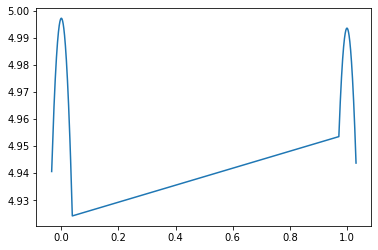

In [397]:
# x = np.random.normal(0, 0.1, 5000)[:, np.newaxis]
x = np.random.binomial(1, 0.5, 5000)
x = np.random.normal(0, 0.01, 5000)*x + np.random.normal(1, 0.01, 5000)*(1-x)
x = x[:, np.newaxis]
bandwidth = 0.1
kernel0 = euclidean_distances(x, x)
kernel0 = np.exp((- kernel0**2)/bandwidth)
x_pdf = np.sum(kernel0, axis = 1)/(5000*bandwidth)

x_sorting_index = np.argsort(x.ravel())
plt.plot(x.ravel()[x_sorting_index], x_pdf[x_sorting_index])
plt.show()
plt.clf()
plt.close()

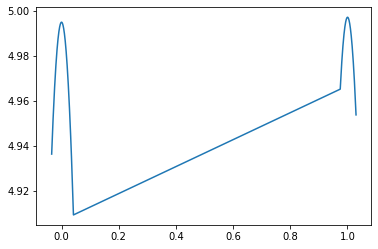

In [398]:
x_group = np.random.binomial(1, 0.9, 5000)
x = np.random.normal(0, 0.01, 5000)*x_group + np.random.normal(1, 0.01, 5000)*(1-x_group)
x = x[:, np.newaxis]

x_majority_weight =  0.5 / np.mean(x_group)
x_minority_weight =  0.5 / np.mean(1 - x_group)
weights = x_group * x_majority_weight + (1 - x_group)*x_minority_weight
bandwidth = 0.1

kernel0 = euclidean_distances(x, x)
kernel0 = np.exp((- kernel0**2)/bandwidth)
kernel0 = kernel0*weights[:, np.newaxis]
x_pdf = np.sum(kernel0, axis = 1)/(np.sum(weights)*bandwidth)
# x_pdf = np.mean(kernel0, axis = 1)

x_sorting_index = np.argsort(x.ravel())
plt.plot(x.ravel()[x_sorting_index], x_pdf[x_sorting_index])
plt.show()
plt.clf()
plt.close()

In [13]:
import tensorflow_probability as tfp

In [14]:
embedding = tf.random.normal((4, 2))
main_labels = tf.cast(
    tf.random.stateless_binomial((4, 1), seed =[0,1], counts = 1, probs = 0.5), 
    dtype = tf.float32)
auxiliary_labels = tf.cast(
    tf.random.stateless_binomial((4, 1), seed =[2,3], counts = 1, probs = 0.5), 
    dtype = tf.float32)
weights_pos = tf.random.uniform(
    (4, 1), minval=0.1, maxval=0.9, dtype=tf.dtypes.float32, seed=None, name=None
)


In [38]:
sigma = 1.0
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
    amplitude=1.0, length_scale=sigma)

kernel_mat = kernel.matrix(embedding, embedding)

if len(auxiliary_labels.shape) == 1:
    auxiliary_labels = tf.expand_dims(auxiliary_labels, axis=-1)

pos_mask = tf.matmul(auxiliary_labels, tf.transpose(auxiliary_labels))
neg_mask = tf.matmul(1.0 - auxiliary_labels,
    tf.transpose(1.0 - auxiliary_labels))
pos_neg_mask = tf.matmul(auxiliary_labels,
    tf.transpose(1.0 - auxiliary_labels))
neg_pos_mask = tf.matmul((1.0 - auxiliary_labels),
    tf.transpose(auxiliary_labels))

pos_kernel_mean = kernel_mat * pos_mask
print(pos_kernel_mean)

tf.Tensor(
[[1.        0.4256901 0.        0.       ]
 [0.4256901 1.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)


In [39]:
pos_kernel_mean = pos_kernel_mean * tf.transpose(weights_pos)
print(pos_kernel_mean.shape)

(4, 4)


In [40]:
pos_kernel_mean = tf.math.divide_no_nan(
    tf.reduce_sum(pos_kernel_mean, axis=1),
    tf.reduce_sum(weights_pos, axis =1))
print(pos_kernel_mean.shape)

(4,)


In [41]:
pos_kernel_mean = tf.math.divide_no_nan(
    tf.reduce_sum(pos_kernel_mean * tf.squeeze(weights_pos)),
    tf.reduce_sum(weights_pos))

print(pos_kernel_mean.shape)

()
